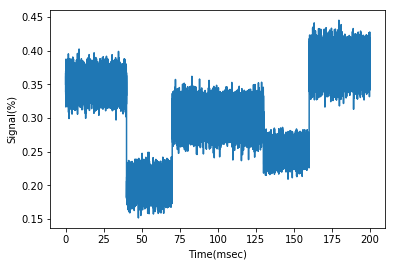

In [1]:
#generate some fake nanopore DNA sequencing data:
import numpy as np
import matplotlib.pyplot as plt
si=float(4E-3)#unite is msec
dataL=np.array([int(1E4), int(0.75*1E4),int(1.5*1E4),int(0.75*1E4),int(1E4)])
mu=np.array([0.35, 0.2, 0.3, 0.25, 0.38])
sigma=np.array([0.27, 0.25, 0.31, 0.22, 0.34])/20
ttrace=np.array([])
Itrace=np.array([])
headt=np.zeros(len(mu))
for i in range(len(mu)):
    if i==0:
        headt[i]=0
    else:
        headt[i]=headt[i-1]+dataL[i-1]*si
    ttrace1=np.arange(1,dataL[i]+1,dtype=float)*si+headt[i]
    Itrace1=np.zeros(dataL[i])+np.random.normal(mu[i],sigma[i],dataL[i])
    ttrace=np.append(ttrace,ttrace1)
    Itrace=np.append(Itrace,Itrace1)
plt.plot(ttrace[:],Itrace[:])
plt.xlabel("Time(msec)")
plt.ylabel("Signal(%)")
plt.show()
data0=np.array([ttrace, Itrace])
data=np.transpose(data0)


In [2]:
from scipy.optimize import fmin
expected_levels_per_second=20
false_positives_per_second=1e-2#bigger will get p close to 0, model more sensitive!!!
#set the threshholds
sampling = data[1,0]-data[0,0] # sampling interval (s)
fs = 1/sampling*1E3#250,000
#filter1=1
#k = filter1/(fs/2) # ratio of filter frequency to Nyquist frequency (if filter is Nyquist frequency, then k=1)
log_prior = np.log(expected_levels_per_second) - np.log(fs - expected_levels_per_second)
p = log_prior# + 1/k * np.log(false_positives_per_second/fs)
print("sampling_rate:",fs,"  log(p_value):", p)
#test the time-series signal obay null hypothesis or not

#fastvariance calculate the variance of the segment data with in[ind1,ind2]
def fastvariance(data0, ind1, ind2):
    ind2 = min(data0.shape[0]-1, int(ind2))
    ind1 = max(0, int(ind1))
    y1 = np.cumsum(data0[:,1]);#E(X)
    y2 = np.cumsum(data0[:,1]*data0[:,1]);#E(X^2)
    num = ind2-ind1;
    mean = (y1[ind2] - y1[ind1])/num;
    variance = (y2[ind2] - y2[ind1])/num - np.power(mean,2);#E(X^2)-E(X)^2
    return variance

#model, this segment of time-series data belong to one Gaussian distribution
#data, the segement of time series data;
#calculate P(M|D);
def log_posterior_odds(data1,index,i1,i3):
    probability = (index-i1) * 0.5*np.log(fastvariance(data1,i1,index)) +\
        (i3-index) * 0.5*np.log(fastvariance(data1,index,i3)) -\
        (i3-i1) * 0.5*np.log(fastvariance(data1,i1,i3)) +\
        log_prior
    return probability
#test the first pivot point!
plist=lambda x: log_posterior_odds(data,x,0,data.shape[0]-1)
xopt=fmin(plist, x0=int(data.shape[0]/2),disp=False)
min_indx=int(xopt[0])
print("The index of the first pivot point:", min_indx)#index, change indx1, the min_indx won't change, but min_value will.
print("log_posterior_prob:",round(plist(min_indx)))

sampling_rate: 250000.0   log(p_value): -9.43340392009
The index of the first pivot point: 17499
log_posterior_prob: -2951.0


In [3]:
indx1=39999
indx2=49999
plist=lambda x: log_posterior_odds(data,x,indx1,indx2)
xopt=fmin(plist, x0=int((indx1+indx2)/2)+100,disp=False)#very danger, x0 don't have limit
min_indx=int(xopt[0])
print(min_indx,plist(min_indx))

45405 -10.9801759118


In [4]:
# calculate the posterior prob recursively, find all pivot points on the time series signal
def P_search(data,indx1,indx2,leveltran_indx):
    minpts=100
    p=-20#this threshold value based on last section calculation.
    plist=lambda x: log_posterior_odds(data,x,indx1,indx2)
    xopt=fmin(plist, x0=int((indx1+indx2)/2),disp=False)
    min_indx=int(xopt[0])
    min_prob=plist(min_indx)
    if min_prob<p:
        leveltran_indx.append(min_indx)
        if min_indx-indx1>minpts:
            P_search(data,indx1,min_indx,leveltran_indx)
        if indx2-min_indx>minpts:
            P_search(data,min_indx,indx2,leveltran_indx)
    return leveltran_indx
leveltran_indx=[]
levellist0=P_search(data,0,data.shape[0]-1,leveltran_indx)
levellist0.append(data.shape[0]-1)
levellist0.insert(0,0)
levellist=np.sort(np.asarray(levellist0))
print("All pivot points(index) along time series signal:\n",levellist)

All pivot points(index) along time series signal:
 [    0  9999 17499 32499 39999 49999]


In [5]:
#catalog all event levels based on the pivots list output before
#use class to store all event levels' start time, end time, mean, std
class event(object):
    def __init__(self):
        self.startt = []
        self.endt = []
        self.I_m =[]
        self.I_std=[]
    def addvalues(self,values):
        self.startt.append(round(values[0],3))
        self.endt.append(values[1])
        self.I_m.append(values[2])
        self.I_std.append(values[3])

DNAevents = event()
for i,j in zip(levellist[:-1],levellist[1:]):
    startt=data[i,0]
    endt=data[j,0]
    I_m=np.mean(data[i:j,1])
    I_std=np.std(data[i:j,1])
    DNAevents.addvalues([startt,endt,I_m,I_std])
    

startt(msec): ['0.004', '40.000', '70.000', '130.000', '160.000']
endt(msec): ['40.000', '70.000', '130.000', '160.000', '200.000']
I_m(%): ['0.350', '0.200', '0.300', '0.250', '0.380']
I_std(%): ['0.014', '0.013', '0.016', '0.011', '0.017']


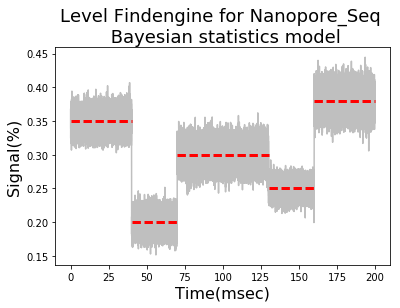

In [6]:
#Visulization events levels along the time-series signals
print("startt(msec):", [ '%.3f' % elem for elem in DNAevents.startt ])
print("endt(msec):", [ '%.3f' % elem for elem in DNAevents.endt ])
print("I_m(%):", [ '%.3f' % elem for elem in DNAevents.I_m ])
print("I_std(%):", [ '%.3f' % elem for elem in DNAevents.I_std ])
plt.plot(data[:,0],data[:,1],color = '0.75')

for i in range(len(DNAevents.startt)):
    timex=[DNAevents.startt[i], DNAevents.endt[i]]
    I_lev=[DNAevents.I_m[i], DNAevents.I_m[i]]
    plt.plot(timex,I_lev,'--r',linewidth=3)
plt.xlabel("Time(msec)",fontsize=16)
plt.ylabel("Signal(%)",fontsize=16)
plt.title("Level Findengine for Nanopore_Seq \n Bayesian statistics model",fontsize=18)
plt.show()